In [97]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import numpy as np
import matplotlib.pyplot as plt 
from commpy import rrcosfilter
from IPython.display import display, Markdown
from ModulationPy.ModulationPy import QAMModem
from src.general_methods.visualizer import Visualizer
from src.optics.myFNFTpy.FNFTpy import nsev_inverse_xi_wrapper, nsev_inverse, nsev
from src.optics.split_step_fourier import SplitStepFourier



In [99]:
# generate system parameters
Nbursts = 1                             # The number of bursts
Nspans = 12                             # The number of spans
La = 12*80/Nspans                       # Transmission span [km]
beta2 = -21.0                           # GVD coefficient [ps^2/km]
gamma = 1.27                            # Nonlinear coefficient in [1/km*W]
eta = 2                                 # SE penalty. eta=(T0+TG)/T0
W = 0.05                                # Total bandwidth, estimated [Thz]
TG = 1.5*np.pi*W*abs(beta2)*La*Nspans   # The required GB [ps]
Nsc = W*TG/(eta-1)                      # The number for subcarriers
Nsc = 2*(Nsc//2)                        # Round it up to the next even number
Nsc = int(2**np.ceil(np.log2(Nsc)))     # Round it up to the next power of 2
T0 = Nsc/W                              # Useful symbol duration, normalization time [ps]
Tb = T0*eta                             # Burst width
no_ss = False                            # If true runs B2B run - no split step
noise = False                           # If true run simulation with noise
Nghost = 0                              # The number of ghost symbols inserted from each side


In [100]:
Nsc

256

In [101]:
# amplification scheme
lumped = True                       # If true use lumped amplification
if not lumped:
    Nspans = 1
dz = 0.2                            # Z-step, [km] - initial step estimate
Nsps = np.ceil(La/dz)               # Required number of steps per span
dz = La/Nsps                        # Adjusting step slightly
L = La*Nspans                       # Total propagation distance
alphadB = 0.2                       # Power loss db/km

# Linear loss
if lumped:
    alpha = alphadB*np.log(10)/10
else:
    alpha = 0
G = np.exp(alpha*La)                # The power gain factor
gamma_eff = gamma                   # The effective gamma-coefficient in r.w.u.
if lumped:
    if G > 1:
        gamma_eff = gamma*(G-1)/(G*np.log(G))

In [102]:
# modulation constellation
mu = 0.1                            # Dimensionless power scaling factor (RRC)
# M = 32      #(matlab's value) non-square dont work in python        # The order of M-QAM
M = 16                              # The order of M-QAM

In [103]:
# carrier characteristics
bet = 0.2                           # The roll-off factor

In [104]:
# normalized units
Tn = T0/(np.pi*(1+bet))             # [ps]
Zn = Tn**2/abs(beta2)               # [km]
Pn = 1/(gamma_eff*Zn)               # [W]

In [105]:
# Setting the time and (nonlinear) frequency arrays for each burst
Nos = 16                                # Oversampling factor (must be even)
Ns = (Nsc+2*Nghost)*Nos                 # The number of meaningful points
Nnft = int(4*2**(np.ceil(np.log2(Ns)))) # The number of points for NFT - round up to a power of 2
# Sometimes additional increase in #points is needed! 
Tnft = np.pi*Nos*Tn                     # The NFT base
dt = Tnft/Nnft                          # The time step in ps
Nb = Tb/dt                              # The number of points in each burst
Nb = 2*round(Nb/2)                      # Make sure it is even
T1 = dt*(-Nnft/2)/Tn
T2 = dt*(Nnft/2-1)/Tn
_, XI = nsev_inverse_xi_wrapper(Nnft,T1,T2,Nnft,display_c_msg=True)
xi = np.arange(-Ns/2, Ns/2)/Nos       # Array of upsampled nonlinear frequencies


In [106]:
# print axes params:
# display(Markdown(f'## Axes params'))
display(Markdown(f'* $\\xi$ = [{xi[0]:.2f}, {xi[-1]:.2f}]'))
display(Markdown(f'* $\\Delta \\xi$ = {xi[1]-xi[0]:.2f}'))
display(Markdown(f'* length of $\\xi$ = {len(xi):d}'))


* $\xi$ = [-128.00, 127.94]

* $\Delta \xi$ = 0.06

* length of $\xi$ = 4096

In [107]:
# my rrc implemenation
def my_rrc(N_rrc, roll_off, Ts, Nos):
    alpha = roll_off
    fs = Nos/Ts
    h_ind, h_rrc = rrcosfilter(N_rrc, alpha, Ts, fs)
    return h_rrc
    

## starting the loop


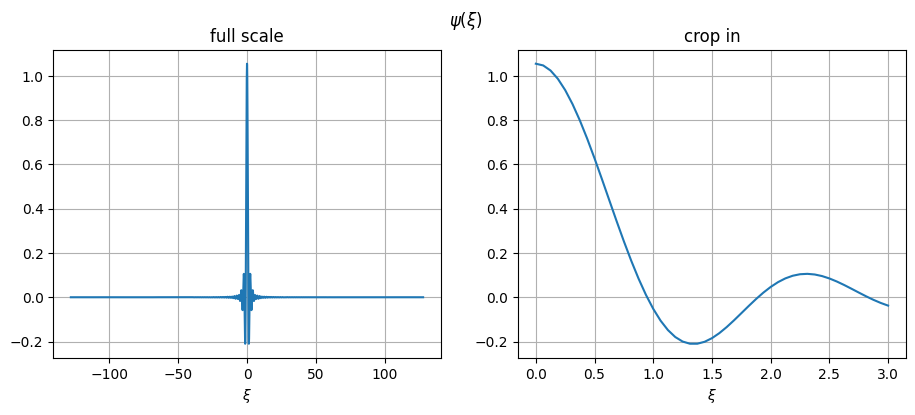

length = 4096
~~~~~~~~~ unit of xi = ??? ~~~~~~~~~


In [108]:
Ts=1
h_ind, psi_xi = rrcosfilter(N=len(xi),alpha=bet,Ts=Ts,Fs=Nos/Ts)
# get indices from xi based on value
zoom_indices = np.where(np.logical_and(xi>=0, xi<=3))
Visualizer.twin_zoom_plot(r'$\psi(\xi)$',psi_xi,zoom_indices,xi,r'$\xi$')
print(f'length = {len(psi_xi)}')

print(f'~~~~~~~~~ unit of xi = ??? ~~~~~~~~~')

In [109]:
# generate message (N words, each word is a number from 1 to M)
NumOfWords=Nsc+2*Nghost

message_int = np.random.randint(0, M, size=NumOfWords)  # Integer message [1,M]
print('[',', '.join(map(str, message_int[:10])),', ... ,',message_int[-1],']', sep='')

print(f'\nlength of message_int: {len(message_int)}')

[11, 14, 13, 5, 15, 1, 13, 15, 10, 3, ... ,0]

length of message_int: 256


In [110]:
def unpackbits(x, num_bits: int):
    # x is a numpy array with N numbers of base M
    # num_bits = log2(M)
    # returns a binary numpy array with shape (N, num_bits)
    assert num_bits <= 8, "limited to uint8, otherwise change the code"
    binary_vec = np.unpackbits(x.astype(np.uint8)) # unpack into 8 bits vectors
    binary_matrix_8bits = binary_vec.reshape(-1, 8) # fold into matrix
    binary_matrix = binary_matrix_8bits[:, -num_bits:] # take last num_bits columns
    binary_vec = binary_matrix.reshape(-1) # unfold into vector
    return binary_vec

In [111]:
# fold down the message into binary vectors - one for each word

sps = int(np.log2(M)) # samples per symbol
message_bin = unpackbits(message_int, sps)
# message_bin.shape
Visualizer.print_bits(message_bin,sps)


_______________________________________________
the bits are: - len=1024
[[1 0 1 1]
 [1 1 1 0]
 [1 1 0 1]
 ...
 [0 1 0 1]
 [0 0 0 1]
 [0 0 0 0]]


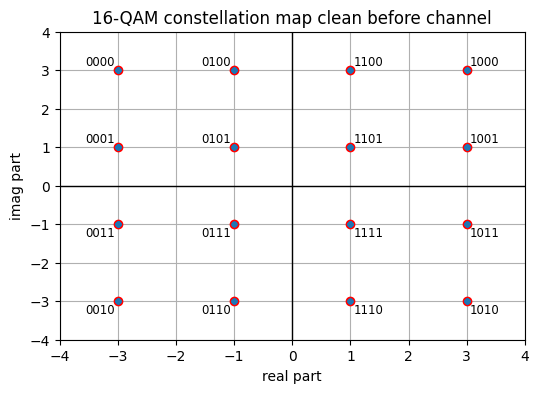

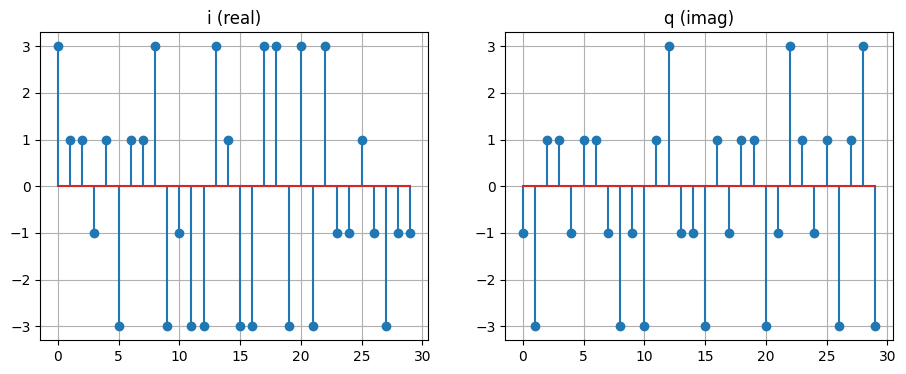

num of symbols = 256


In [112]:
# modulate
c = QAMModem(M, soft_decision=False).modulate(message_bin) # Symbols sequence including ghost symbols
# plot
Visualizer.plot_constellation_map_with_points(c, M, 'clean before channel')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
Visualizer.my_plot(np.real(c[0:30]), function='stem', name='i (real)', ax=ax1, hold=1)
Visualizer.my_plot(np.imag(c[0:30]), function='stem', name='q (imag)', ax=ax2)
print(f'num of symbols = {len(c)}')

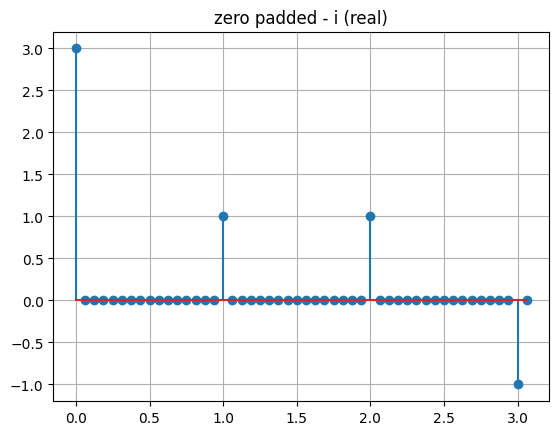

vec length = 4096, over_sampling period = 16


In [113]:
# upsample
x2 = np.zeros(Nos*len(c), dtype=np.complex64)
x2[::Nos] = c
c = x2
# plot
t_axis = np.arange(0, len(c))/Nos
Visualizer.my_plot(t_axis[0:50], np.real(c[0:50]), name='zero padded - i (real)', function='stem')
print(f'vec length = {len(c)}, over_sampling period = {Nos}')

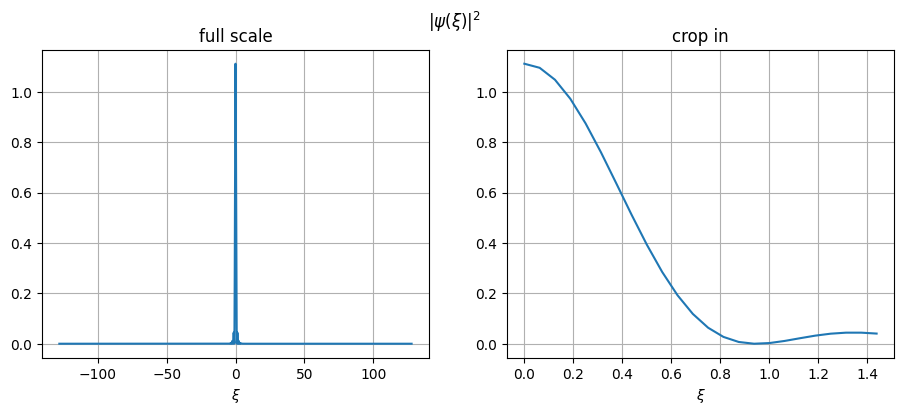

$$\begin{align*} u(\xi) = \sum_{n=-N_s/2}^{N_s/2-1} c_n \psi(\xi-n) \end{align*}$$

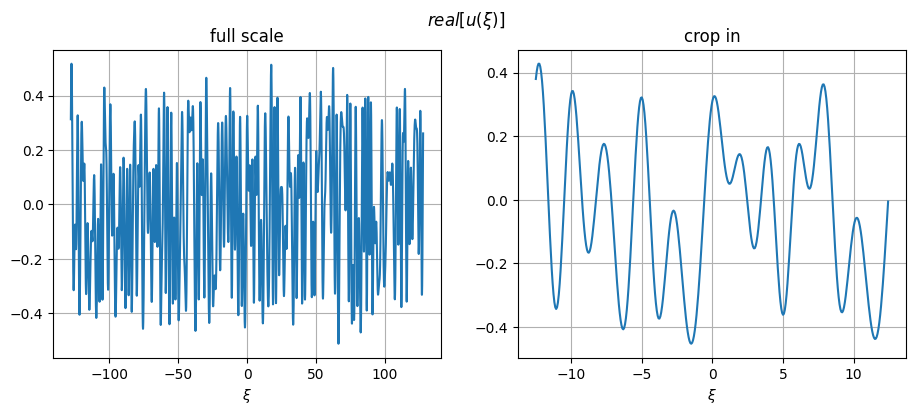

filter len = 4096, signal len = 4096


In [114]:
# convolve with rrc
u_in = mu*np.fft.ifft(np.fft.fft(psi_xi)*np.fft.fft(c))

#plot
N_rrc = len(psi_xi)
zm = range(N_rrc//2, N_rrc//2 + 24)
Visualizer.twin_zoom_plot(r'$|\psi(\xi)|^2$', np.abs(psi_xi) ** 2, zm, xi,xlabel=r'$\xi$')
display(Markdown(r"$$\begin{align*} u(\xi) = \sum_{n=-N_s/2}^{N_s/2-1} c_n \psi(\xi-n) \end{align*}$$"))
Visualizer.twin_zoom_plot(r'$real[ u(\xi) ]$', np.real(u_in), range(N_rrc//2-200, N_rrc//2+200),
                          xi, xlabel=r'$\xi$')

print(f'filter len = {N_rrc}, signal len = {len(u_in)}')

In [115]:
Nnft

16384

length of b_in is 4096
Nnft is 16384


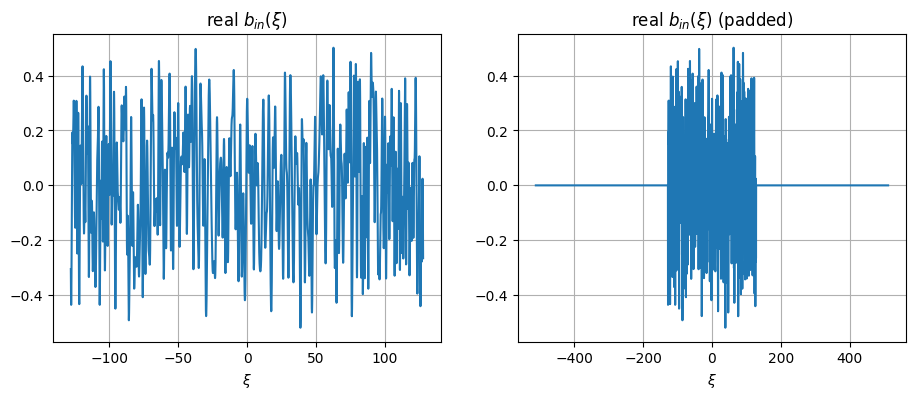

In [116]:
# scaling

b_in=np.sqrt(1-np.exp(-np.abs(u_in)**2))*np.exp(1j*np.angle(u_in))

# Pre-compensation
b_in=b_in*np.exp(-1j*xi**2*(L/Zn))

# Pad with zeros symmetrically
b_in_padded=np.zeros(Nnft,dtype=complex)
b_in_padded[int(Nnft/2-Ns/2):int(Nnft/2+Ns/2)]=b_in
# xi_padded = np.arange(-Nnft/2, Nnft/2)/Nos
xi_padded = np.linspace(XI[0], XI[1], Nnft);


# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
Visualizer.my_plot(xi,np.real(b_in),name=r'real $b_{in}(\xi)$',xlabel=r'$\xi$',hold=True,ax=ax1)
print(f'length of b_in is {len(b_in)}')
print(f'Nnft is {Nnft}')
Visualizer.my_plot(xi_padded, np.real(b_in_padded),name=r'real $b_{in}(\xi)$ (padded)',xlabel=r'$\xi$', ax=ax2)



## 5) INFT
$q(t) = \mathcal F^{-1}\{b_p(\xi)\}$                 
* $ \xi \in [X_1,X_2] = [-511.9, 512.0] $
$ \qquad \; N_\xi = N_{NFT} = 16384 $

* $ t_{pad} \in [T_1,T_2] = [-25.13,25.13] $
$ \qquad  N_t = D = \lceil N_\xi \rceil = 16384 $


length of INFT(x) = 16384
signal power = 5.22e+01
signal bw = [-4.48e+00:4.53e+00]


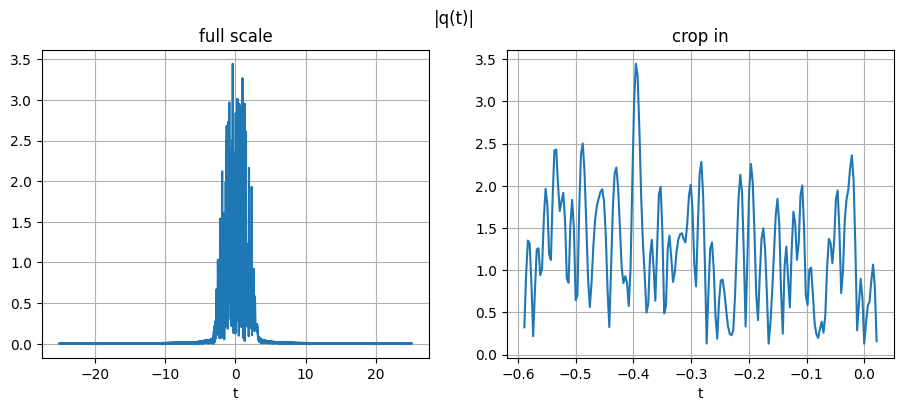

$ t_{padded} \in [-25.13, 25.13] = [T1,T2]= \tau $

In [117]:
# INFT2 (params from matlab)

contspec = b_in_padded
bound_states = []
discspec = []
cst = 1  # continuous spectrum type - default is None
dst = 0  # default is None
t_padded = np.linspace(T1,T2, Nnft)


res = nsev_inverse(xi_padded, t_padded, contspec, bound_states, discspec,
                   cst=cst, dst=dst)
q_in = res['q']


# MATLAB: qin=mex_fnft_nsev_inverse(bin_padded, XI, [], [], Nnft, tau, 1,'cstype_b_of_xi')
display(Markdown(f"""
## 5) INFT
$q(t) = \\mathcal F^{{-1}}\\{{b_p(\\xi)\\}}$                 
* $ \\xi \\in [X_1,X_2] = [{XI[0]:.1f}, {XI[1]:.1f}] $
$ \\qquad \; N_\\xi = N_{{NFT}} = {Nnft} $

* $ t_{{pad}} \\in [T_1,T_2] = [{T1:.2f},{T2:.2f}] $
$ \\qquad  N_t = D = \\lceil N_\\xi \\rceil = {Nnft} $
"""))
# plot
print(f'length of INFT(x) = {len(q_in)}')
Visualizer.print_signal_specs(q_in, t_padded)
Visualizer.twin_zoom_plot('|q(t)|', np.abs(q_in), range(8000, 8200), t_padded, 't')

display(Markdown(rf'$ t_{{padded}} \in [{t_padded[0]:.2f}, {t_padded[-1]:.2f}] = [T1,T2]= \tau $'))

length of q_b = 2458


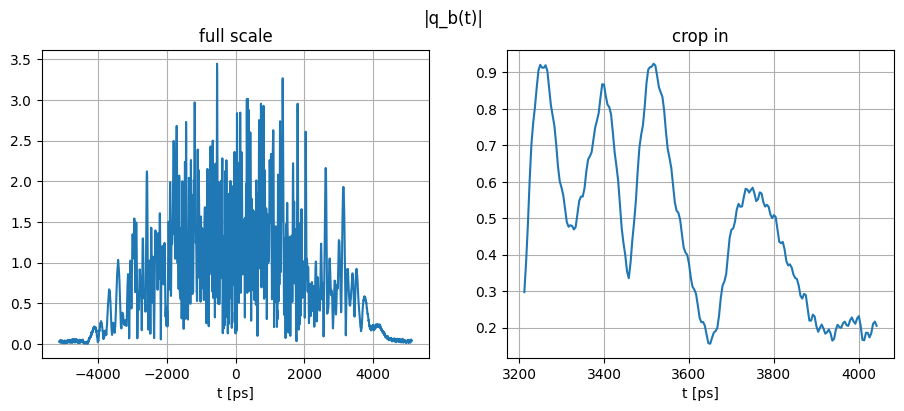

matlab version:  $ t \in [-5120.83, 5116.67]\qquad $ length = 2458

my version: $ t_{clipped} \in [-3.77, 3.77] \qquad $ length = 2458

In [118]:
# Keeping only the central part of length N_b
qb=q_in[(Nnft-Nb)//2:(Nnft+Nb)//2]

t_clipped=t_padded[(Nnft-Nb)//2:(Nnft+Nb)//2]
Nb=min(Nb,Nnft) # If the estimated burst size is less than NFT base - truncate the latter
t=np.arange(-Nb/2,Nb/2)*dt # Time array in r.w.u. 



print(f'length of q_b = {len(qb)}')
Visualizer.twin_zoom_plot('|q_b(t)|', np.abs(qb), range(2000, 2200), t, 't [ps]')


display(Markdown(rf'matlab version:  $ t \in [{t[0]:.2f}, {t[-1]:.2f}]\qquad $ length = {len(t)}'))
display(Markdown(rf'my version: $ t_{{clipped}} \in [{t_clipped[0]:.2f}, {t_clipped[-1]:.2f}] \qquad $ length = {len(t_clipped)}'))

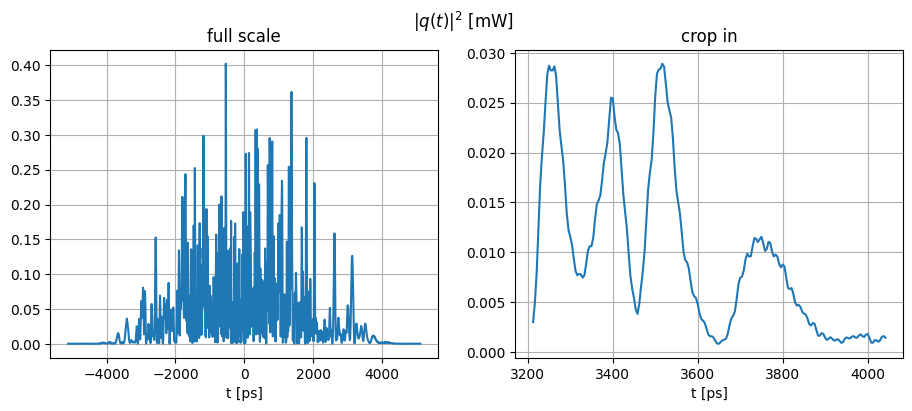

In [119]:
# Updating different parts of the main array
# left=0
# right=left+Nb
# q=np.zeros(Nb,dtype=np.complex128) # The dimensionles field in optical domain obtained by concatenation
# q[left:right]=qb

q=qb
q=q*np.sqrt(Pn) # Converting to the r.w.u.
power_q_mw=np.abs(q)**2*1e3 # Power in mW

Visualizer.twin_zoom_plot(r'${|q(t)|}^2$ [mW]', power_q_mw, range(2000, 2200), t, 't [ps]')


In [120]:
# channel (nothing for now)
qz=q # TODO: replace with ssf channel

## SSF channel

SSF params: N = 439


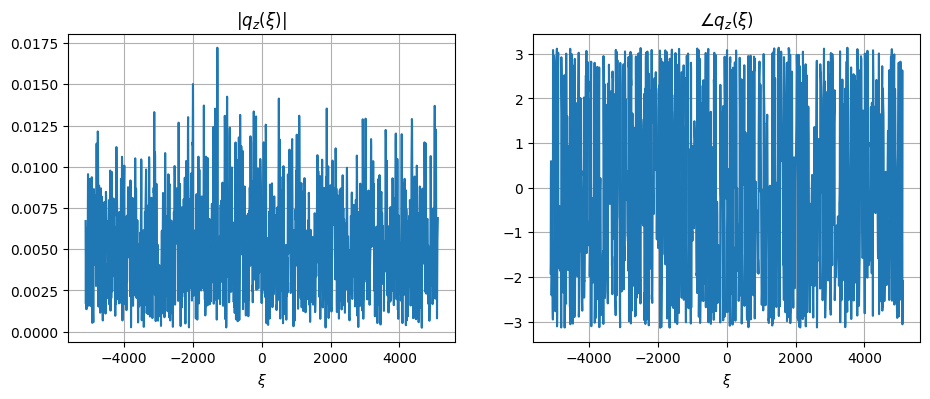

In [121]:
ssf = SplitStepFourier(
    b2=beta2,
    gamma=gamma,
    t0=T0,
    dt=dt,
    z_n=Zn,
    dz=200,
    with_noise=True,
    verbose=True
)

qz = ssf(q)

Visualizer.plot_amp_and_phase(t, qz, r'$\xi$', r'q_z(\xi)')


## Forward NFT

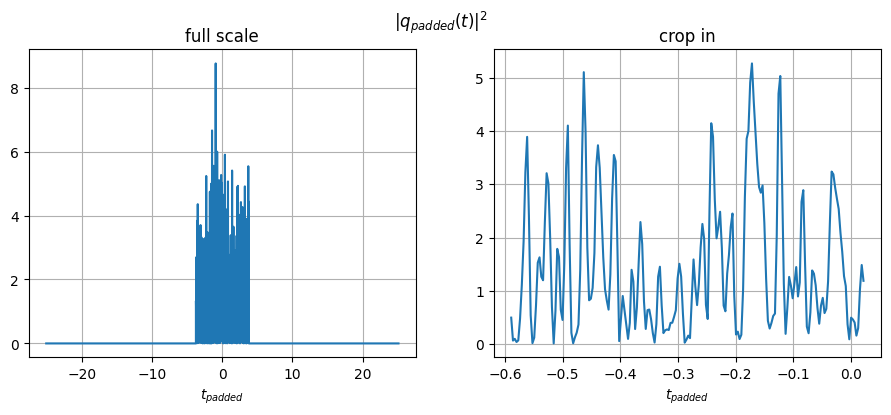

In [122]:
# padding and descaling

qz=qz/np.sqrt(Pn) # rescale the pulse to soliton units

qb=qz

#pad with zeros to Nnft size
q_padded = np.zeros(Nnft,dtype=complex)
if Nnft>Nb:
    q_padded[(Nnft-Nb)//2:(Nnft+Nb)//2] = qb
else:
    q_padded = qb[(Nb-Nnft)//2:(Nb+Nnft)//2]

# plot
Visualizer.twin_zoom_plot(r'$|q_{padded}(t)|^2$',
                          np.abs(q_padded)**2,
                          range(8000,8200),
                          t_padded, r'$t_{padded}$')

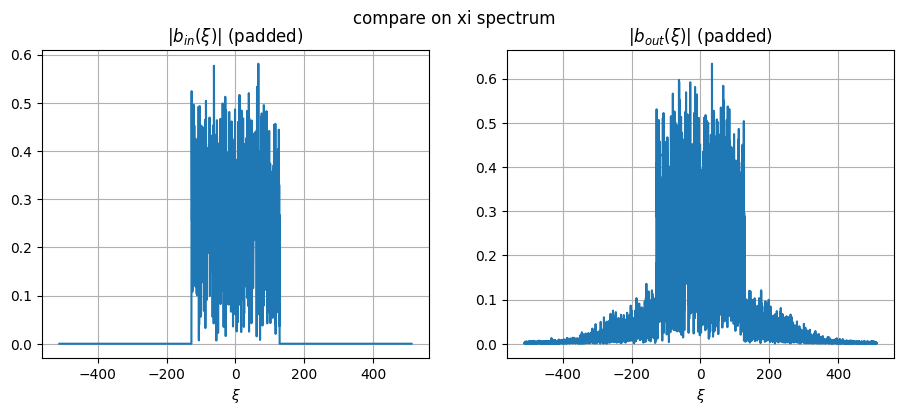

In [123]:
# NFT

res=nsev(q_padded,t_padded,XI[0],XI[1],
              M=Nnft,display_c_msg=True,cst=cst)
assert res['return_value'] == 0, "NFT failed"
b_out_padded = res['cont_b']

# Plot the result
Visualizer.double_plot('compare on xi spectrum',
                       np.abs(b_in_padded),np.abs(b_out_padded),
                       xi_padded,xi_padded,
                       name1=r'$|b_{in}(\xi)|$ (padded)', name2=r'$|b_{out}(\xi)|$ (padded)',
                          xlabel1=r'$\xi$', xlabel2=r'$\xi$')


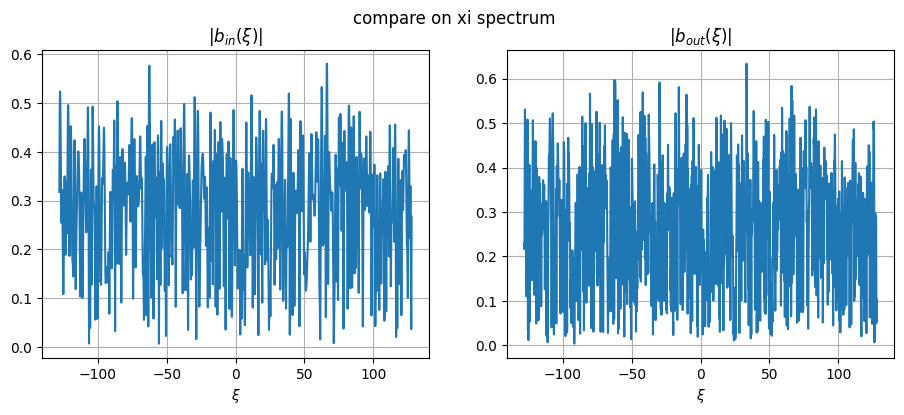

In [124]:
# Select the central N_s = N_{sc} N_{os} samples
b_out=b_out_padded[(Nnft-Ns)//2:(Nnft+Ns)//2]

Visualizer.double_plot('compare on xi spectrum',
                       np.abs(b_in),np.abs(b_out),
                       xi,xi,
                       name1=r'$|b_{in}(\xi)|$', name2=r'$|b_{out}(\xi)|$',
                          xlabel1=r'$\xi$', xlabel2=r'$\xi$')

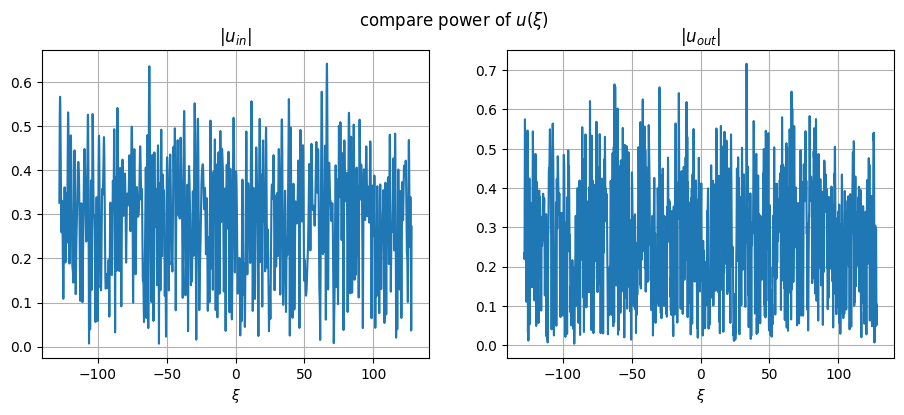

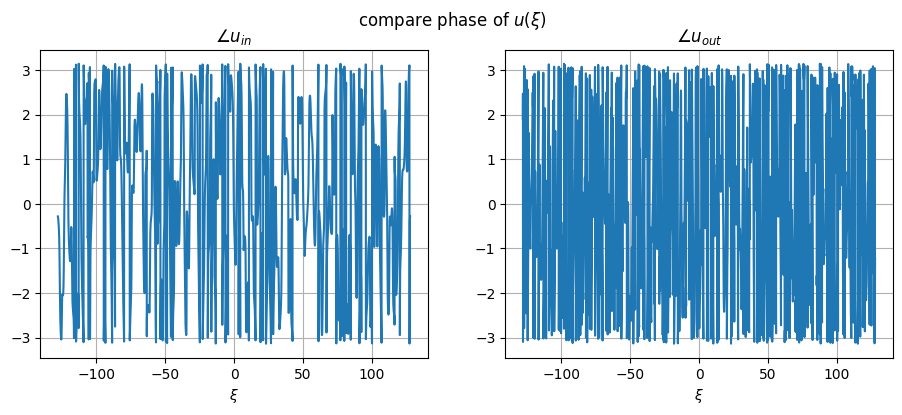

In [125]:
# post compensation
if no_ss:
    b_out = b_out * np.exp(1j * xi**2 * (L/Zn))
else:
    b_out = b_out * np.exp(-1j * xi**2 * (L/Zn))

# reverse scaling
# matlab:     uout(ii,:)=sqrt(-log(1-abs(bout).^2)).*exp(1i*angle(bout));
# python:
u_out = np.sqrt(-np.log(1 - np.abs(b_out)**2)) * np.exp(1j * np.angle(b_out))

# plot
Visualizer.double_plot(r'compare power of $u(\xi)$',
                       np.abs(u_in), np.abs(u_out),
                       xi,xi,
                       r'$|u_{in}|$', r'$|u_{out}|$',
                       xlabel1=r'$\xi$', xlabel2=r'$\xi$',
)

Visualizer.double_plot(r'compare phase of $u(\xi)$',
                       np.angle(u_in), np.angle(u_out),
                       xi,xi,
                       r'$ \angle u_{in}$', r'$\angle u_{out}$',
                       xlabel1=r'$\xi$', xlabel2=r'$\xi$',
)

# plot on top


## Demoduation and data processing (OFDM)

In [126]:
len(t_axis)

4096

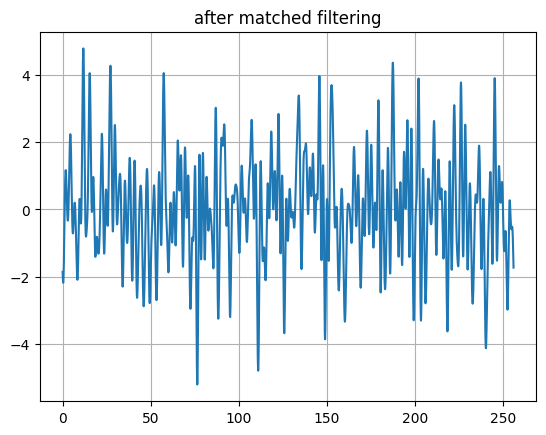

lenght of c_out: 4096 (=Ns)


In [127]:
# match filtering:
# matlab:     c=ifft(fft(psi_xi).*fft(uout(ii,:)))/(mu*Nos); %Matched filtering
# python:     
c_out = np.fft.ifft(np.fft.fft(psi_xi)*np.fft.fft(u_out))/(mu*Nos) #Matched filtering
Visualizer.my_plot(t_axis, np.real(c_out), name='after matched filtering')
print(f'lenght of c_out: {len(c_out)} (=Ns)')


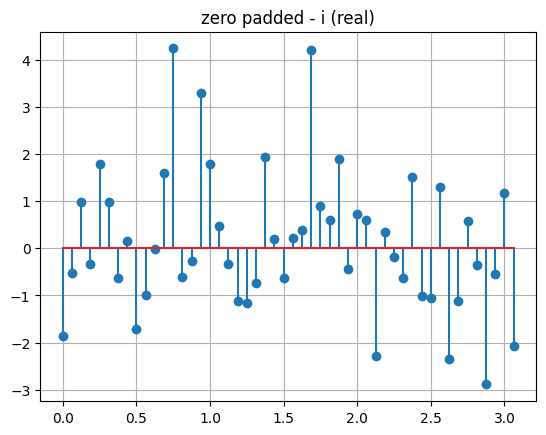

x9.shape =  (256,)


In [128]:
# downsample
start = 0
stop = Ns  # + over_sampling
step = Nos
x9 = c_out[start:stop:step]

# from old debug: sampling the analog vector into discrete bits
# start = N_rrc
# stop = - N_rrc  # + over_sampling
# step = Nos
# x9 = c[start:stop:step] / Nos

Visualizer.my_plot(t_axis[0:50], np.real(x9[0:50]), name='zero padded - i (real)', function='stem')
print('x9.shape = ', x9.shape)

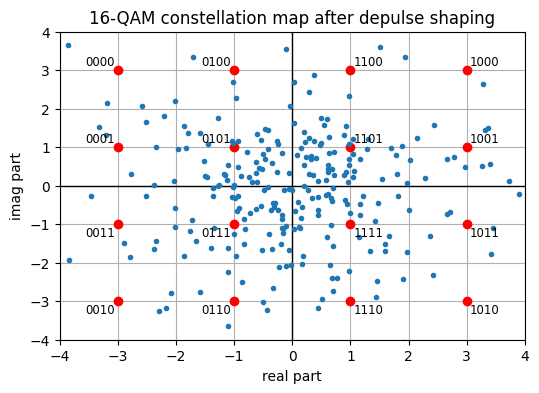

In [129]:
# constelattion diagram
Visualizer.plot_constellation_map_with_points(x9, M, 'after depulse shaping')
